In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset_dict = load_dataset("wachawich/REG-Forecasting_v2")
dataset = dataset_dict["train"]

import pandas as pd
df = dataset.to_pandas()
print(df.head())
print(df.columns)
df.value


c:\Users\Xenosz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   time        date  day  month  year  fueltype type-name  solar_count  \
0     0  2020-01-01    1      1  2020         1     Solar        34.95   
1     0  2020-01-01    1      1  2020         2      Wind        34.95   
2     1  2020-01-01    1      1  2020         1     Solar        34.95   
3     1  2020-01-01    1      1  2020         2      Wind        34.95   
4     2  2020-01-01    1      1  2020         1     Solar        34.95   

   wind_turbine_count  value  ...  sunrise_time_h  sunrise_time_m  \
0                2400   1403  ...               7              10   
1                2400    225  ...               7              10   
2                2400    -35  ...               7              10   
3                2400    222  ...               7              10   
4                2400    -30  ...               7              10   

   sunset_time_h  sunset_time_m  sin_time  cos_time  day_of_month_sin  \
0             16             51  0.000000  1.000000          0.2012

0          1403
1           225
2           -35
3           222
4           -30
          ...  
103120     1398
103121    10192
103122     1158
103123    10026
103124      979
Name: value, Length: 103125, dtype: int64

In [2]:
df_solar = df[df["fueltype"] == 1].reset_index(drop=True)
df_wind  = df[df["fueltype"] == 2].reset_index(drop=True)


In [3]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51563 entries, 0 to 51562
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      51563 non-null  int64  
 1   date                      51563 non-null  object 
 2   day                       51563 non-null  int32  
 3   month                     51563 non-null  int32  
 4   year                      51563 non-null  int32  
 5   fueltype                  51563 non-null  int64  
 6   type-name                 51563 non-null  object 
 7   solar_count               51563 non-null  float64
 8   wind_turbine_count        51563 non-null  int64  
 9   value                     51563 non-null  int64  
 10  shortwave_radiation       51563 non-null  float64
 11  direct_radiation          51563 non-null  float64
 12  diffuse_radiation         51563 non-null  float64
 13  direct_normal_irradiance  51563 non-null  float64
 14  cloudc

In [4]:
wind_features = [
    'day',
    'month',
    'day_of_year',
    'sin_doy',
    'cos_doy',
    'season',
    'windspeed_10m',
    'winddirection_10m',
    'windspeed_100m',
    'winddirection_100m',
    'windgusts_10m',
    'temperature_2m',
    'relativehumidity_2m',
    'dewpoint_2m',
    'surface_pressure',
    'vapour_pressure_deficit',
    'cloudcover',
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_high',
    'precipitation',
    'rain',
    'snowfall',
    'sin_time',
    'cos_time'
]
feature_cols = [c for c in wind_features if c in df.columns]

target_col = "value"   


Model

In [5]:
def create_sequences(X, y, window=48):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)


In [6]:
def prepare_dataset(df_part, feature_cols, target_col, window=48, batch=64):
    
    X_raw = df_part[feature_cols].astype(float).values
    y_raw = df_part[target_col].astype(float).values.reshape(-1, 1)
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_scaled = x_scaler.fit_transform(X_raw)
    y_scaled = y_scaler.fit_transform(y_raw)
    
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window)
    
    split = int(len(X_seq) * 0.99)
    X_train, y_train = X_seq[:split], y_seq[:split]
    X_test,  y_test  = X_seq[split:], y_seq[split:]
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch, shuffle=False)
    
    return {
        "X_train_t": X_train_t,
        "y_train_t": y_train_t,
        "X_test_t":  X_test_t,
        "y_test_t":  y_test_t,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
    }


In [7]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [8]:
def train_gru(model, train_loader, epochs=40, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} - Loss: {total_loss:.6f}")


In [9]:
wind_data = prepare_dataset(df_wind, wind_features, target_col, window=72)

input_dim = len(wind_features)

wind_model = GRUModel(input_dim)

print("\n=== Training Wind GRU ===")
train_gru(wind_model, wind_data["train_loader"], epochs=30)



=== Training Wind GRU ===
Epoch 1/30 - Loss: 12.156306
Epoch 2/30 - Loss: 8.532707
Epoch 3/30 - Loss: 7.688862
Epoch 4/30 - Loss: 7.126264
Epoch 5/30 - Loss: 6.685195
Epoch 6/30 - Loss: 6.168493
Epoch 7/30 - Loss: 5.653709
Epoch 8/30 - Loss: 5.086340
Epoch 9/30 - Loss: 4.531636
Epoch 10/30 - Loss: 4.050747
Epoch 11/30 - Loss: 3.665334
Epoch 12/30 - Loss: 3.269096
Epoch 13/30 - Loss: 2.927485
Epoch 14/30 - Loss: 2.690561
Epoch 15/30 - Loss: 2.438766
Epoch 16/30 - Loss: 2.264630
Epoch 17/30 - Loss: 2.096963
Epoch 18/30 - Loss: 1.968980
Epoch 19/30 - Loss: 1.857814
Epoch 20/30 - Loss: 1.757800
Epoch 21/30 - Loss: 1.650267
Epoch 22/30 - Loss: 1.573055
Epoch 23/30 - Loss: 1.527238
Epoch 24/30 - Loss: 1.464863
Epoch 25/30 - Loss: 1.413702
Epoch 26/30 - Loss: 1.372338
Epoch 27/30 - Loss: 1.337697
Epoch 28/30 - Loss: 1.266579
Epoch 29/30 - Loss: 1.267590
Epoch 30/30 - Loss: 1.212567


In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error

device = "cuda" if torch.cuda.is_available() else "cpu"

X_test_t = wind_data["X_test_t"]
y_test_t = wind_data["y_test_t"]
y_scaler = wind_data["y_scaler"]

wind_model.eval()
with torch.no_grad():
    preds_test_scaled = wind_model(X_test_t.to(device)).cpu().numpy()

y_test_scaled = y_test_t.numpy()

y_test_real     = y_scaler.inverse_transform(y_test_scaled)
preds_test_real = y_scaler.inverse_transform(preds_test_scaled)

rmse_real = np.sqrt(mean_squared_error(y_test_real, preds_test_real))
print("Wind RMSE (real scale):", rmse_real)


Wind RMSE (real scale): 1035.1455211708158


In [11]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

wind_model.to(device)
wind_model.eval()

scaler = wind_data['y_scaler'] 

preds_train_list = []

print(f"Start predicting on device: {device}")

with torch.no_grad():
    for X_batch, y_batch in wind_data["train_loader"]:
        X_batch = X_batch.to(device) 
        y_pred = wind_model(X_batch)
        preds_train_list.append(y_pred.cpu().numpy())

if len(preds_train_list) > 0:
    preds_train_scaled = np.concatenate(preds_train_list, axis=0)
    preds_train_real = scaler.inverse_transform(preds_train_scaled).flatten()
    
    print("Success!")
    print("Shape  preds_train_real:", preds_train_real.shape)
else:
    print("Error: Prediction")

Start predicting on device: cuda
Success!
Shape  preds_train_real: (50976,)


In [12]:
preds_test_list = []

print("Start predicting Test set...")
with torch.no_grad():
    for X_batch, y_batch in wind_data["test_loader"]:
        X_batch = X_batch.to(device) 
        y_pred = wind_model(X_batch)
        preds_test_list.append(y_pred.cpu().numpy())

if len(preds_test_list) > 0:
    preds_test_scaled = np.concatenate(preds_test_list, axis=0)
    preds_test_real = scaler.inverse_transform(preds_test_scaled).flatten()
    print("Test Prediction Shape:", preds_test_real.shape)

Start predicting Test set...
Test Prediction Shape: (515,)


In [13]:
from torch.utils.data import DataLoader, TensorDataset

train_loader_plot = DataLoader(
    TensorDataset(wind_data['X_train_t'], wind_data['y_train_t']), 
    batch_size=64, 
    shuffle=False 
)

preds_train_list = []
wind_model.eval() 

print("Predicting Train set (Ordered for Plotting)...")
with torch.no_grad():
    for X_batch, y_batch in train_loader_plot: 
        X_batch = X_batch.to(device)
        y_pred = wind_model(X_batch)
        preds_train_list.append(y_pred.cpu().numpy())

scaler = wind_data['y_scaler']
preds_train_scaled = np.concatenate(preds_train_list, axis=0)
preds_train_real = scaler.inverse_transform(preds_train_scaled).flatten()


Predicting Train set (Ordered for Plotting)...


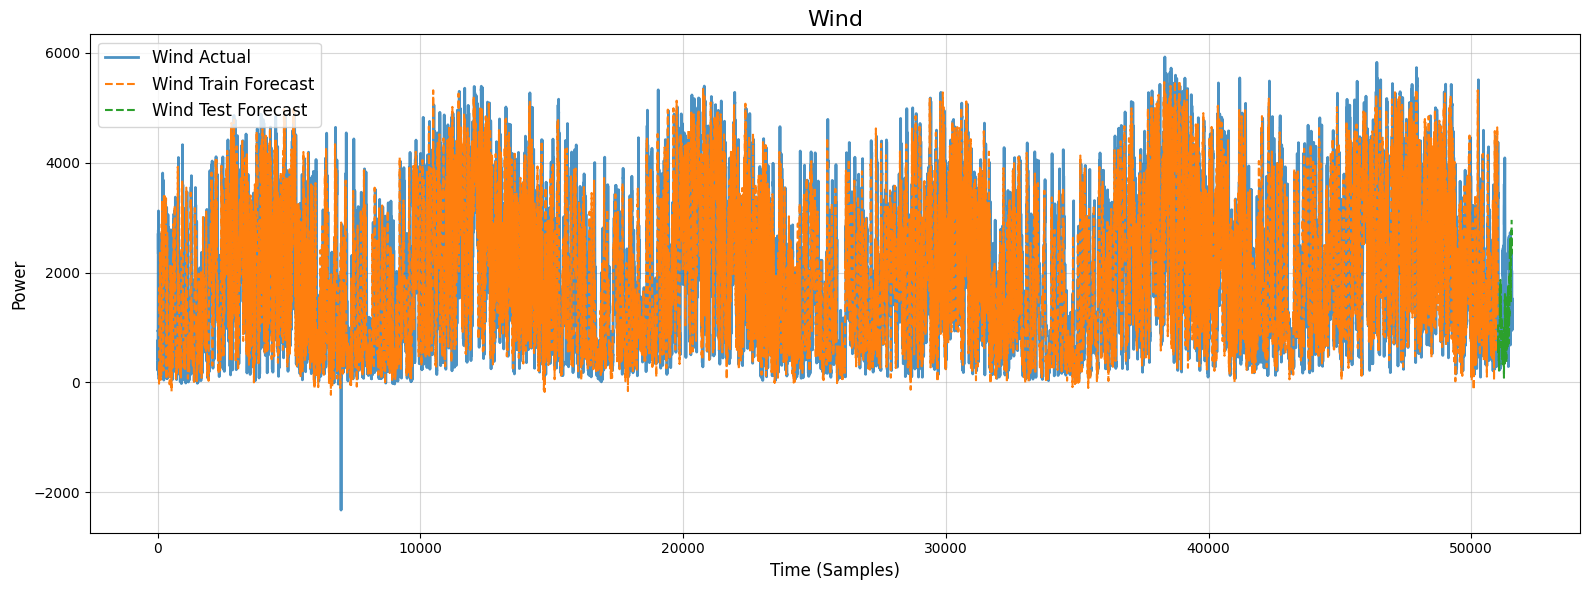

In [14]:
import matplotlib.pyplot as plt

look_back = 48  
train_len = len(preds_train_real)
test_len  = len(preds_test_real)

train_range = np.arange(look_back, look_back + train_len)

test_range = np.arange(look_back + train_len, look_back + train_len + test_len)

plt.figure(figsize=(16, 6)) 

plt.plot(df_wind[target_col].values, label='Wind Actual', color='#1f77b4', linewidth=2, alpha=0.8)

plt.plot(train_range, preds_train_real, 
        label='Wind Train Forecast', linestyle='--', color='#ff7f0e', linewidth=1.5)

plt.plot(test_range, preds_test_real, 
        label='Wind Test Forecast', linestyle='--', color='#2ca02c', linewidth=1.5)

plt.title('Wind', fontsize=16)
plt.xlabel('Time (Samples)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(loc='upper left', fontsize=12) 
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()


=== Overall Performance (Total Steps: 51491) ===
Accuracy OverAll: 85.37%
Accuracy Train:      85.35%
Accuracy Test:       87.03%


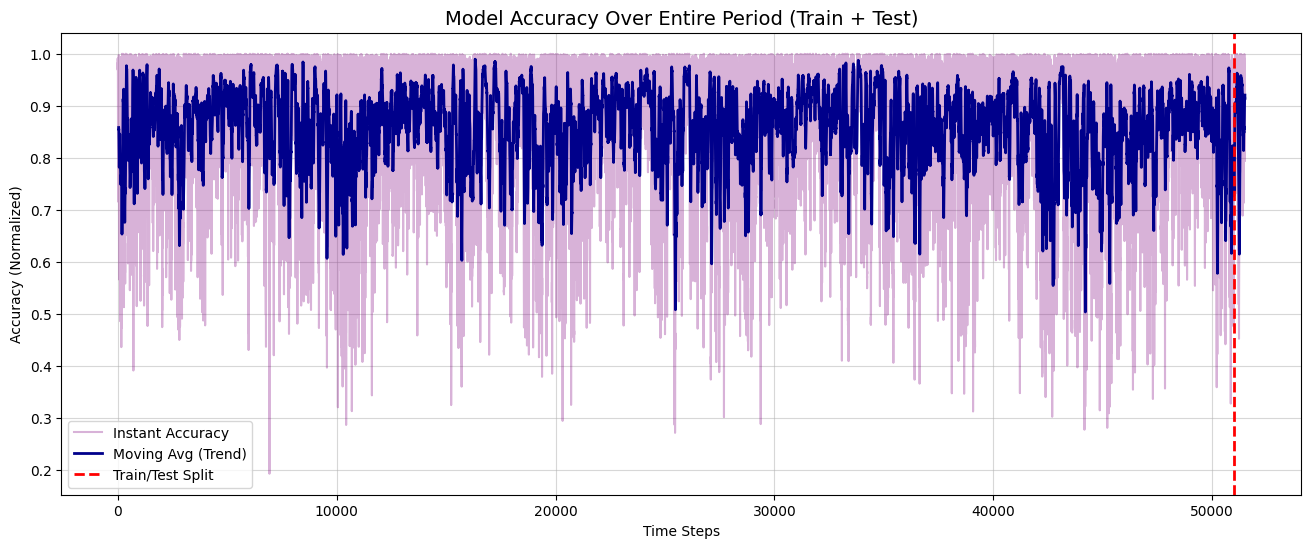

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

all_preds = np.concatenate([preds_train_real, preds_test_real])

look_back = 48
total_len = len(all_preds)
all_actual = df_wind[target_col].values[look_back : look_back + total_len]

max_capacity = all_actual.max()
abs_err = np.abs(all_preds - all_actual)

acc_per_point = 1.0 - (abs_err / max_capacity)
acc_per_point = np.clip(acc_per_point, 0, 1) 

print(f"=== Overall Performance (Total Steps: {total_len}) ===")
print(f"Accuracy OverAll: {acc_per_point.mean() * 100:.2f}%")
print(f"Accuracy Train:      {acc_per_point[:len(preds_train_real)].mean() * 100:.2f}%")
print(f"Accuracy Test:       {acc_per_point[len(preds_train_real):].mean() * 100:.2f}%")

plt.figure(figsize=(16, 6))

time_steps = np.arange(total_len)

plt.plot(time_steps, acc_per_point, color='purple', alpha=0.3, label='Instant Accuracy')

rolling_acc = pd.Series(acc_per_point).rolling(window=48).mean() 
plt.plot(time_steps, rolling_acc, color='darkblue', linewidth=2, label='Moving Avg (Trend)')

split_point = len(preds_train_real)
plt.axvline(x=split_point, color='red', linestyle='--', linewidth=2, label='Train/Test Split')

plt.title('Model Accuracy Over Entire Period (Train + Test)', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Accuracy (Normalized)')
plt.legend()
plt.grid(True, alpha=0.5)

plt.show()